# Finding Eigenvalues by Solving a Differential Equation

In this notebook, we will solve a differential equation whose equilibrium points are the eigenvectors of a real, symmetric matrix. We take the approach of using a neural network to approximate solutions to the differential equation. Approximate solutions correspond to evolutions that end up at the equilibrium points. We then use the approximate solutions to find the eigenvalues of the matrix.

In [2]:
import numpy as np
import matplotlib.pyplot as plt


from ffnn_pde_solver import PDESolver
from trial_functions import x_trial_normalized, generate_symmetric

2022-12-18 17:27:11.507888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 17:27:12.880784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-18 17:27:12.880861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-18 17:27:12.880867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Neural Network

In [4]:
from eigenvector_utils import is_linearly_dependent, is_eigenvector, compute_eigenvalue

In [ ]:
def search(
    A,
    layers=[64, 64],
    epochs=1000, 
    learning_rate=1e-4, 
    regularization=0,
    maxiter=20,
    timesteps=100
    ):
    """Search for eigenvectors of A.
    
    Parameters:
        A (np.ndarray): the matrix
        layers (list): the number of neurons in each layer
        epochs (int): the number of epochs to train for
        learning_rate (float): the learning rate
        regularization (float): the regularization parameter
        maxiter (int): the maximum number of iterations
        timesteps (int): the number of timesteps to use in the trial function
        
    Returns:
        list: a list of eigenvectors of A"""
    found = []
    N = A.shape[0]
    iter = 0
    while len(found) < N and iter < maxiter:
        iter += 1
        x0 = np.random.rand(N)
        for x in found:
            x0 -= x0 @ x * x
        x0 /= np.linalg.norm(x0)
        solver = PDESolver(
            hidden_layers=layers,
            problem="eigen", 
            A=A, 
            x0=x0,
            learning_rate=learning_rate,
            regularization=regularization
            )
        t = np.linspace(0, timesteps, timesteps+1)
        solver.fit(t, epochs=epochs, verbose=0)
        nn_output = solver(t)
        x = x_trial_normalized(t, x0, nn_output)[-1]


        if is_linearly_dependent(x, found):
            print("Linearly dependent")
            continue
        elif is_eigenvector(A, x):
            found.append(x)
            print("Found eigenvector")
            print("cost", solver.get_cost(x))
        else:
            print("Not an eigenvector")
            print("cost", solver.get_cost(x))
    return found

For a 4x4 matrix, we randomly initialize the starting position, and see which eigenvectors it converges to.

In [ ]:
N = 4
A = generate_symmetric(N, seed=100)
print(A)
eigenvectors = []
eigenvalues = []
for i in range(20):
    x0 = np.random.randn(N)
    solver = PDESolver(
        hidden_layers=[64, 64],
        problem="eigen", 
        A=A, 
        x0=x0,
        learning_rate=1e-4,
        )
    t = np.linspace(0, 100, 101)
    solver.fit(t, epochs=10000, verbose=0)
    nn_output = solver(t)
    x = x_trial_normalized(t, x0, nn_output)[-1]
    if is_eigenvector(A, x):
        eigenvectors.append(x)
        eigenvalues.append(compute_eigenvalue(A, x))
        print("Found eigenvector")
    else:
        print("Not an eigenvector")
        print("cost", solver.get_cost(x))


[[-1.74976547  0.6620006   0.48176999 -0.41801554]
 [ 0.6620006   0.51421884  0.23809056 -0.12659813]
 [ 0.48176999  0.23809056 -0.45802699  0.55394215]
 [-0.41801554 -0.12659813  0.55394215 -0.10441114]]
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector
Not an eigenvector
cost 1.2903221
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector
Not an eigenvector
cost 2423.9417
Not an eigenvector
cost 3.907393
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector


In [ ]:
val, vec = np.linalg.eig(A)
print(val)

[-2.16840096 -0.74046923  0.80921466  0.30167077]


In [90]:
print(eigenvalues)
print(sum(1 for eigen in eigenvalues if np.abs(eigen - val[0]) < 1e-2))
print(sum(1 for eigen in eigenvalues if np.abs(eigen - val[1]) < 1e-2))
print(sum(1 for eigen in eigenvalues if np.abs(eigen - val[2]) < 1e-2))
print(sum(1 for eigen in eigenvalues if np.abs(eigen - val[3]) < 1e-2))

[0.8091948551795289, 0.3016702394456285, 0.3016710992585486, 0.3016654088963811, 0.8092019551932068, 0.8091961815549924, 0.8092138421755517, 0.8092088955046781, 0.3016716331869425, 0.3016828165235507, 0.809206279695366, 0.8092103199183968, 0.8092103247566006, 0.8091818395280043, 0.8092082346582237, 0.8092107478538968, 0.8092105566832709]
0
0
12
5


We repeat the simulation, with -A

In [92]:
N = 4
A = -generate_symmetric(N, seed=100)
print(A)
eigenvectors = []
eigenvalues = []
for i in range(20):
    x0 = np.random.randn(N)
    solver = PDESolver(
        hidden_layers=[64, 64],
        problem="eigen", 
        A=A, 
        x0=x0,
        learning_rate=1e-4,
        )
    t = np.linspace(0, 100, 101)
    solver.fit(t, epochs=10000, verbose=0)
    nn_output = solver(t)
    x = x_trial_normalized(t, x0, nn_output)[-1]
    if is_eigenvector(A, x):
        eigenvectors.append(x)
        eigenvalues.append(compute_eigenvalue(A, x))
        print("Found eigenvector")
    else:
        print("Not an eigenvector")
        print("cost", solver.get_cost(x))


[[ 1.74976547 -0.6620006  -0.48176999  0.41801554]
 [-0.6620006  -0.51421884 -0.23809056  0.12659813]
 [-0.48176999 -0.23809056  0.45802699 -0.55394215]
 [ 0.41801554  0.12659813 -0.55394215  0.10441114]]
Found eigenvector
Found eigenvector
Found eigenvector
Found eigenvector
Not an eigenvector
cost 698.24066
Not an eigenvector
cost 24730.527
Found eigenvector
Not an eigenvector
cost 13.656033
Found eigenvector
Found eigenvector
Found eigenvector
Not an eigenvector
cost 0.38927644
Found eigenvector
Not an eigenvector
cost 9.637467
Not an eigenvector
cost 1030.1357
Not an eigenvector
cost 713.6283
Not an eigenvector
cost 4.173482
Found eigenvector
Found eigenvector
Found eigenvector


In [102]:
val, vec = np.linalg.eig(A)
print(val)

[ 2.16840096  0.74046923 -0.80921466 -0.30167077]


In [100]:
print(eigenvalues)
print(sum(1 for eigen in eigenvalues if np.abs(eigen - val[0]) < 1e-2))
print(sum(1 for eigen in eigenvalues if np.abs(eigen - val[1]) < 1e-2))
print(sum(1 for eigen in eigenvalues if np.abs(eigen - val[2]) < 1e-2))
print(sum(1 for eigen in eigenvalues if np.abs(eigen - val[3]) < 1e-2))

[-0.3016696402570911, -0.30166308652582546, -0.30166629034647435, -0.30166063844849567, -0.3016690523860387, -0.30166746544815176, -0.30166941578192297, -0.3016697097335996, -0.30165436819700325, -0.301650354285913, -0.30167016697308274, -0.30167062332962213]
0
0
0
12


We now check how a solution can look

In [51]:
x0 = np.random.randn(N)
model = PDESolver([128, 128, 128], activation_function="tanh", problem="eigen", A=A, x0=x0)
t = np.linspace(0, 10, 30)

model.fit(t, epochs=2000)
nn_output = model(t)
x_trial = x_trial_normalized(t, x0, nn_output)

Epoch 1/2000
1/1 [==============================] - 1s 616ms/step - loss: 1.0045
Epoch 2/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.2899
Epoch 3/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.8482
Epoch 4/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7449
Epoch 5/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.4125
Epoch 6/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.2745
Epoch 7/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.2105
Epoch 8/2000
1/1 [==============================] - 0s 5ms/step - loss: 0.1906
Epoch 9/2000
1/1 [==============================] - 0s 4ms/step - loss: 0.2150
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.2754
Epoch 11/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.2686
Epoch 12/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.2157
Epoch 13/2000
1/1 [============================

[[-0.89800394  0.31825527  0.30109039 -0.04058418]
 [ 0.18212817 -0.35566361  0.91648537 -0.01967978]
 [ 0.30980641  0.72651797  0.23256309  0.56754386]
 [-0.25384687 -0.49435677 -0.12374793  0.8221068 ]]
[-0.29256941 -0.84374591 -0.41780425 -0.16713944]


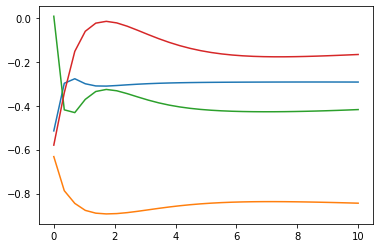

In [52]:
plt.plot(t, x_trial)
eig, val = np.linalg.eig(A)
print(val)
print(x_trial[-1])

In [53]:
print(compute_eigenvalue(A, x_trial[-1]))
print(eig)

0.7466873709295178
[-2.16840096 -0.74046923  0.80921466  0.30167077]


We now search for eigenvectors of a 6x6 matrix

In [104]:
N = 6
A = generate_symmetric(N, seed=1)

found =  search(A, epochs=10000, learning_rate=1e-4, maxiter=50, timesteps=100)

Found eigenvector
cost 1.2197601
Linearly dependent
Found eigenvector
cost 1.1952684
Linearly dependent
Linearly dependent
Linearly dependent
Not an eigenvector
cost 0.29543585
Not an eigenvector
cost 0.47962892
Not an eigenvector
cost 0.9476151
Not an eigenvector
cost 0.40310943
Linearly dependent
Not an eigenvector
cost 3.4566603
Found eigenvector
cost 61.31965
Linearly dependent
Linearly dependent
Not an eigenvector
cost 318.34244
Not an eigenvector
cost 0.08278144
Linearly dependent
Not an eigenvector
cost 0.8156931
Linearly dependent
Linearly dependent
Linearly dependent
Not an eigenvector
cost 0.29933557
Linearly dependent
Linearly dependent
Linearly dependent
Not an eigenvector
cost 628.04865
Not an eigenvector
cost 0.34950408
Linearly dependent
Not an eigenvector
cost 0.61604846
Not an eigenvector
cost 66.944855
Linearly dependent
Linearly dependent
Linearly dependent
Linearly dependent
Linearly dependent
Linearly dependent
Linearly dependent
Linearly dependent
Found eigenvecto

In [110]:
print(*found, sep="\n")
print()
estimated_eigvals = [compute_eigenvalue(A, x) for x in found]
analytical_eigvals = np.linalg.eig(A)[0]
print("eigenvalues:", *estimated_eigvals)
print("analytical:", analytical_eigvals)
for e1 in estimated_eigvals:
    for e2 in analytical_eigvals:
        if np.abs(e1 - e2) < 1e-2:
            print("error:", np.abs(e1 - e2))

[-0.16774999  0.05669362  0.24245069  0.13832778  0.91931373  0.21352082]
[ 0.28607756  0.58180535  0.24739055  0.13795233 -0.22603991  0.66957836]
[ 0.43948075 -0.69776873  0.36236621  0.38878054 -0.07881999  0.17692741]
[ 0.75808865  0.2781949   0.11509149 -0.19418328  0.23588481 -0.49123757]

eigenvalues: -0.4628222346811439 -2.02195146497588 -0.8403715880796914 3.1434020729327408
analytical: [ 3.14342005  2.25564252 -2.02196713  0.78718539 -0.84038169 -0.46282022]
error: 2.0194357522873574e-06
error: 1.5662404724281487e-05
error: 1.0101823006980482e-05
error: 1.7979886956176472e-05


We successfully find 4 eigenvectors of the matrix A. The eigenvalues are quite accurate

Below, you can see another example of how a solution can look

In [6]:
N = 6
A = generate_symmetric(N)

x0 = np.random.randn(N)
model = PDESolver([128, 128, 128], activation_function="tanh", problem="eigen", A=A, x0=x0)
t = np.linspace(0, 3, 100)

model.fit(t, epochs=2000)
nn_output = model(t)
x_trial = x_trial_normalized(t, x0, nn_output)

Epoch 1/2000


2022-12-18 17:28:15.184354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-18 17:28:15.184423: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 [==============================] - 1s 4ms/step - loss: 4.9480
Epoch 2/2000
4/4 [==============================] - 0s 3ms/step - loss: 4.2604
Epoch 3/2000
4/4 [==============================] - 0s 3ms/step - loss: 3.9198
Epoch 4/2000
4/4 [==============================] - 0s 4ms/step - loss: 3.6415
Epoch 5/2000
4/4 [==============================] - 0s 4ms/step - loss: 3.3034
Epoch 6/2000
4/4 [==============================] - 0s 3ms/step - loss: 3.0377
Epoch 7/2000
4/4 [==============================] - 0s 3ms/step - loss: 2.8119
Epoch 8/2000
4/4 [==============================] - 0s 3ms/step - loss: 2.5924
Epoch 9/2000
4/4 [==============================] - 0s 4ms/step - loss: 2.4259
Epoch 10/2000
4/4 [==============================] - 0s 3ms/step - loss: 2.2520
Epoch 11/2000
4/4 [==============================] - 0s 4ms/step - loss: 2.1183
Epoch 12/2000
4/4 [==============================] - 0s 4ms/step - loss: 2.0526
Epoch 13/2000
4/4 [==============================] - 0s 3ms/st

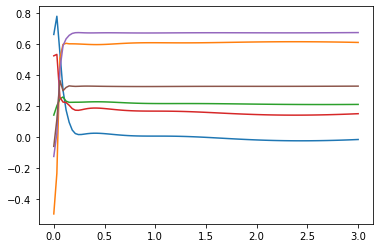

In [8]:
plt.plot(t, x_trial)

In [11]:
print(x_trial[-1])
print(compute_eigenvalue(A, x_trial[-1]))
print(np.linalg.eig(A)[0])

[-0.01745715  0.61005481  0.20938378  0.14937558  0.6738281   0.32761173]
-2.966912111001013
[-2.96774678 -1.82212821  1.52803295  0.04044609 -0.19324486 -0.11012639]
